Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


293/293 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.6183 - loss: 0.9695 - val_accuracy: 0.6748 - val_loss: 0.7605 - learning_rate: 1.0000e-04
Epoch 2/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.6844 - loss: 0.7606 - val_accuracy: 0.6936 - val_loss: 0.7079 - learning_rate: 1.0000e-04
Epoch 3/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.6972 - loss: 0.7132 - val_accuracy: 0.7051 - val_loss: 0.6884 - learning_rate: 1.0000e-04
Epoch 4/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.7072 - loss: 0.6957 - val_accuracy: 0.7200 - val_loss: 0.6730 - learning_rate: 1.0000e-04
Epoch 5/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.7321 - loss: 0.6612 - val_accuracy: 0.7213 - val_loss: 0.6681 - learning_rate: 1.0000e-04
Epoch 6/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.7384 - loss: 0.6505 - val_accuracy: 0.7234 - val_loss: 0.6562 - learning_rate: 1.0000e-04
Epoch 7/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.74

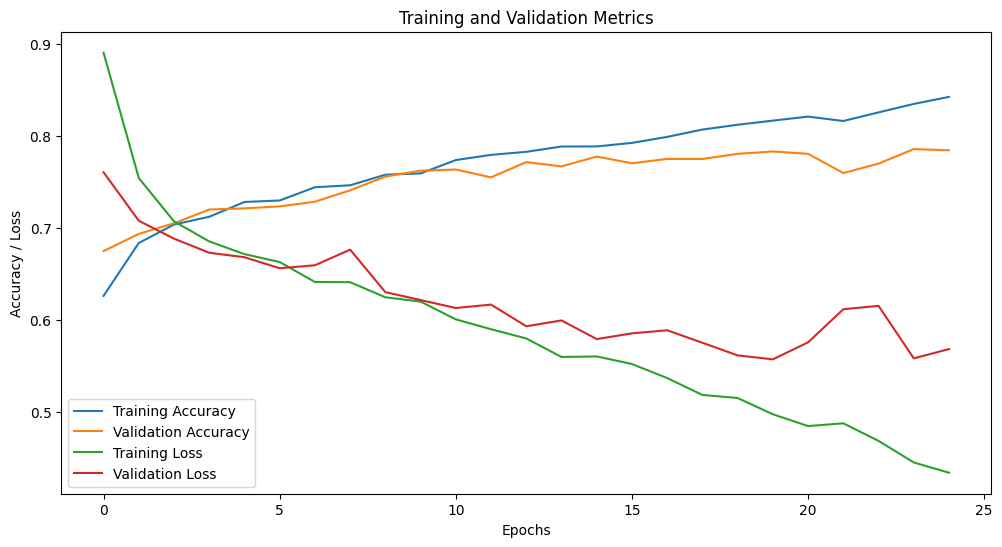

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Load dataset
file_path = '/kaggle/input/twitter-us-airline/Twitter_US_Airline/Tweets.csv'  # Replace with your dataset path
data = pd.read_csv(file_path)

# Data preprocessing
data = data[['text', 'airline_sentiment']].dropna()  # Keep relevant columns and remove nulls
label_encoder = LabelEncoder()
data['sentiment_encoded'] = label_encoder.fit_transform(data['airline_sentiment'])  # Encode sentiments

# Tokenization and padding
max_words = 20000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(data['text'])
sequences = tokenizer.texts_to_sequences(data['text'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, 
    data['sentiment_encoded'], 
    test_size=0.2, 
    random_state=42
)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Load GloVe embeddings
embedding_dim = 100
embedding_index = {}
with open('/kaggle/input/glove-6b-100d/glove.6B.100d.txt', 'r', encoding='utf-8') as f:  # Replace with the GloVe path
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Create embedding matrix
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Define the model
inputs = Input(shape=(max_len,))
embedding = Embedding(input_dim=num_words, 
                      output_dim=embedding_dim, 
                      weights=[embedding_matrix], 
                      input_length=max_len, 
                      trainable=False)(inputs)
bilstm = Bidirectional(LSTM(128, return_sequences=True))(embedding)
lstm_out = LSTM(64)(bilstm)
dense1 = Dense(64, activation='relu')(lstm_out)
dropout = Dropout(0.5)(dense1)
outputs = Dense(3, activation='softmax')(dropout)

model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,  # Increased epochs
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {accuracy:.2f}')

# Save the model
model.save('bilstm_glove_sentiment_analysis.h5')

# Visualize training performance
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.show()
